In [201]:
import re
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [202]:
meme_df = pd.read_csv('data/meme_coins.csv')
stable_df = pd.read_csv('data/stable_coins.csv')

In [203]:
meme_df['Class'] = 0
stable_df['Class'] = 1

In [204]:
df = pd.concat((meme_df, stable_df), axis=0)

In [205]:
df.head(5)

,name,symbol,price,market cap,24h volume,24h,7d,30d,Class
0,Dogecoin,DOGE,$0.1989,$30.14B,$1.15B,0.89%,4.88%,-10.95%,0
1,Shiba Inu,SHIB,$0.00001017,$6.00B,$57.83M,-0.31%,2.59%,-12.81%,0
2,MemeCore,M,$2.21,$3.74B,$5.03M,-1.83%,15.43%,-2.61%,0
3,Pepe,PEPE,$0.000007124,$2.95B,$279.69M,-0.43%,5.43%,-21.55%,0
4,Pudgy Penguins,PENGU,$0.02091,$1.45B,$142.39M,-0.16%,-2.68%,-22.12%,0


In [206]:
df.tail(5)

,name,symbol,price,market cap,24h volume,24h,7d,30d,Class
45,Australian Digital Dollar,AUDD,$0.6519,$0,$19.79K,0.15%,0.70%,-76.54%,1
46,Felix feUSD,FEUSD,$0.9958,$0,$1.09M,-0.10%,-0.69%,0.54%,1
47,Last USD,USDXL,$0.9894,$0,$23.41K,-0.01%,-0.27%,-0.57%,1
48,DecentralizedEURO,DEURO,$1.17,$0,$8.57K,1.07%,-0.36%,0.44%,1
49,Frax USD,FRXUSD,$0.9998,$0,$12.57K,0.02%,-0.03%,-0.01%,1


In [207]:
df.drop(['name'], axis=1, inplace=True)

In [208]:
df.head()

,symbol,price,market cap,24h volume,24h,7d,30d,Class
0,DOGE,$0.1989,$30.14B,$1.15B,0.89%,4.88%,-10.95%,0
1,SHIB,$0.00001017,$6.00B,$57.83M,-0.31%,2.59%,-12.81%,0
2,M,$2.21,$3.74B,$5.03M,-1.83%,15.43%,-2.61%,0
3,PEPE,$0.000007124,$2.95B,$279.69M,-0.43%,5.43%,-21.55%,0
4,PENGU,$0.02091,$1.45B,$142.39M,-0.16%,-2.68%,-22.12%,0


In [209]:
def parse_abbreviated_number(value):
    if pd.isna(value):
        return value
    
    value = str(value).strip().replace('$', '').replace(',', '')
    
    multipliers = {
        'K': 10**3, 'M': 10**6, 'B': 10**9, 'T': 10**12
    }
    
    if value[-1].upper() in multipliers:
        number = float(value[:-1])
        multiplier = value[-1].upper()
        return number * multipliers[multiplier]
    else:
        return float(value)

In [210]:
df_pca = df.drop(['symbol'], axis=1)
df_pca = df_pca.drop(['Class'], axis=1)
for col in df_pca.columns:
    if df_pca[col].dtype == 'object':
        df_pca[col] = df[col].astype(str).apply(lambda x: re.sub(r'[^\d.-]', '', x))
df_pca['24h'] = df_pca['24h'].map(lambda x: abs(float(x)))
df_pca['7d'] = df_pca['7d'].map(lambda x: abs(float(x)))
df_pca['30d'] = df_pca['30d'].map(lambda x: abs(float(x)))

In [211]:
df_pca.head()

,price,market cap,24h volume,24h,7d,30d
0,0.1989,30.14,1.15,0.89,4.88,10.95
1,0.00001017,6.00,57.83,0.31,2.59,12.81
2,2.21,3.74,5.03,1.83,15.43,2.61
3,0.000007124,2.95,279.69,0.43,5.43,21.55
4,0.02091,1.45,142.39,0.16,2.68,22.12


In [212]:
standard_scaler = StandardScaler()
df_pca = standard_scaler.fit_transform(df_pca)

In [213]:
pca = PCA()
pca_result = pca.fit_transform(df_pca)

In [214]:
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
pca_df['symbol'] = df['symbol'].values

In [215]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,symbol
0,-0.118074,-0.019175,0.114626,-0.587288,-0.042780,0.450674,DOGE
1,-0.440691,-0.252636,-0.003953,-0.508778,-0.310269,0.252076,SHIB
2,0.623595,-0.429874,0.169544,-0.419507,0.576146,1.395350,M
3,-0.126422,-1.241080,-0.534852,0.226305,-0.569073,-0.044459,PEPE
4,-0.276304,-0.623962,-0.175415,-0.264166,-0.693039,-0.044520,PENGU


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24065 (\N{CJK UNIFIED IDEOGRAPH-5E01}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23433 (\N{CJK UNIFIED IDEOGRAPH-5B89}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


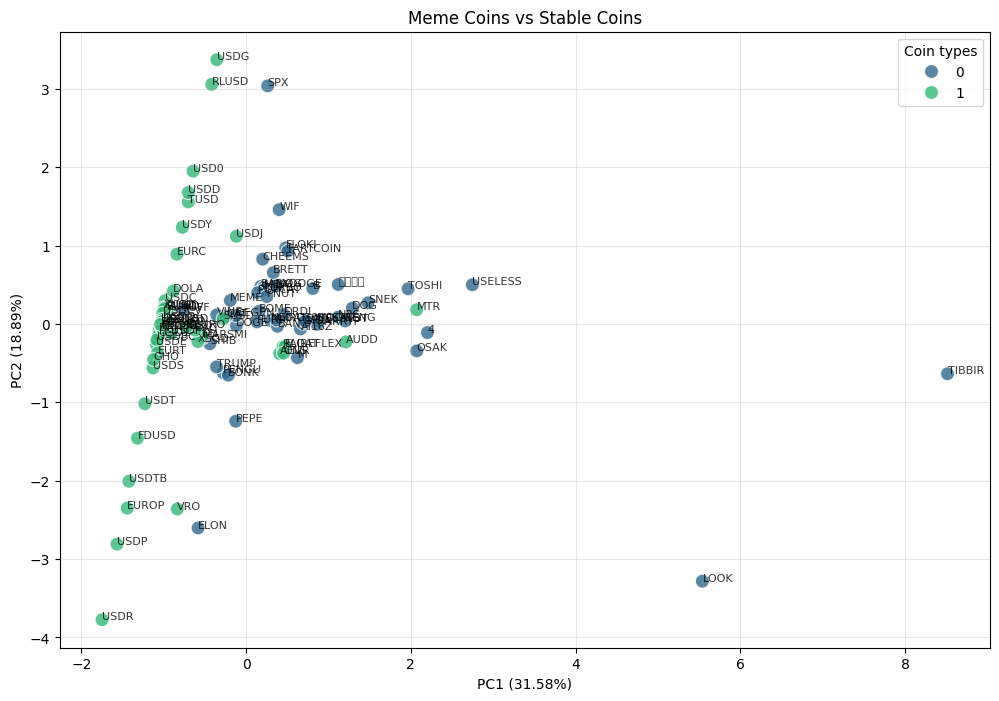

In [216]:
plt.figure(figsize=(12, 8))

plot_df = pca_df[['PC1', 'PC2', 'symbol']].copy()
plot_df['Class'] = df['Class'].values

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Class', 
                palette='viridis', s=100, alpha=0.8)

for i, row in plot_df.iterrows():
    plt.annotate(row['symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('Meme Coins vs Stable Coins')
plt.legend(title='Coin types')
plt.grid(True, alpha=0.3)
plt.show()

In [217]:
X = pca_df[['PC1', 'PC2']]
y = df['Class']

In [218]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [219]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


<Axes: >

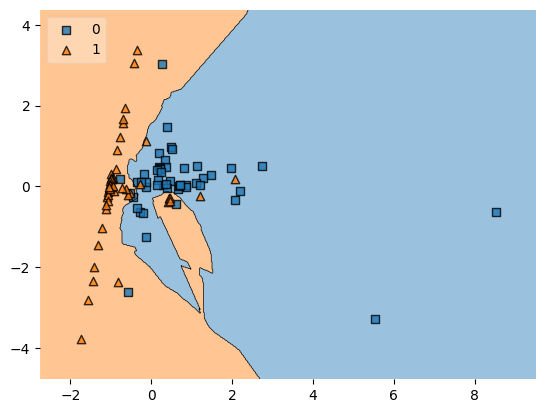

In [220]:
from mlxtend.plotting import plot_decision_regions 
plot_decision_regions(X.to_numpy(), y.to_numpy(), clf=knn, legend=2)  

In [221]:
nearest_centroid = NearestCentroid()
nearest_centroid.fit(X_train, y_train)

,metric,'euclidean'
,shrink_threshold,None
,priors,'uniform'


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but NearestCentroid was fitted with feature names
  warnings.warn(


<Axes: >

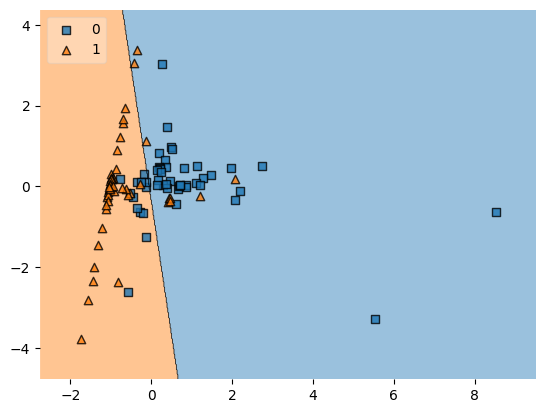

In [222]:
plot_decision_regions(X.to_numpy(), y.to_numpy(), clf=nearest_centroid, legend=2)  

In [223]:
svc_linear = SVC(kernel='linear')
svc_linear.fit(X_train, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24065 (\N{CJK UNIFIED IDEOGRAPH-5E01}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23433 (\N{CJK UNIFIED IDEOGRAPH-5B89}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-package

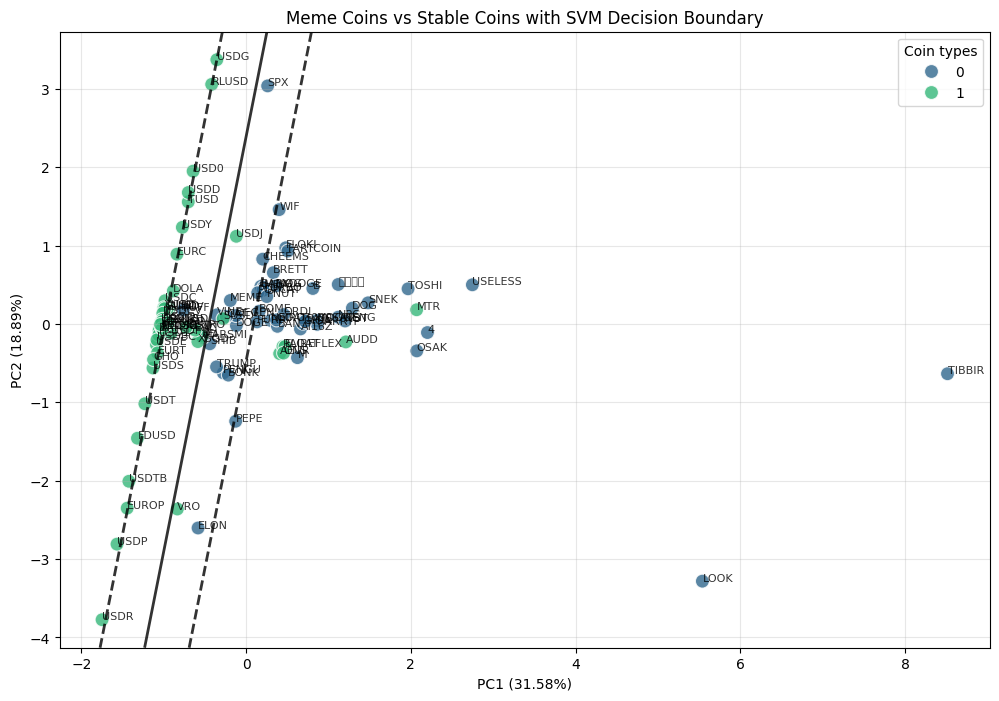

In [224]:
plt.figure(figsize=(12, 8))

plot_df = pca_df[['PC1', 'PC2', 'symbol']].copy()
plot_df['Class'] = df['Class'].values

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Class', 
                palette='viridis', s=100, alpha=0.8)

for i, row in plot_df.iterrows():
    plt.annotate(row['symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

Z = svc_linear.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.8, 
           linestyles=['--', '-', '--'], linewidths=2)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('Meme Coins vs Stable Coins with SVM Decision Boundary')
plt.legend(title='Coin types')
plt.grid(True, alpha=0.3)
plt.show()

In [225]:
svc_poly = SVC(C=10, kernel='poly')
svc_poly.fit(X_train, y_train)

,C,10
,kernel,'poly'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24065 (\N{CJK UNIFIED IDEOGRAPH-5E01}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23433 (\N{CJK UNIFIED IDEOGRAPH-5B89}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-package

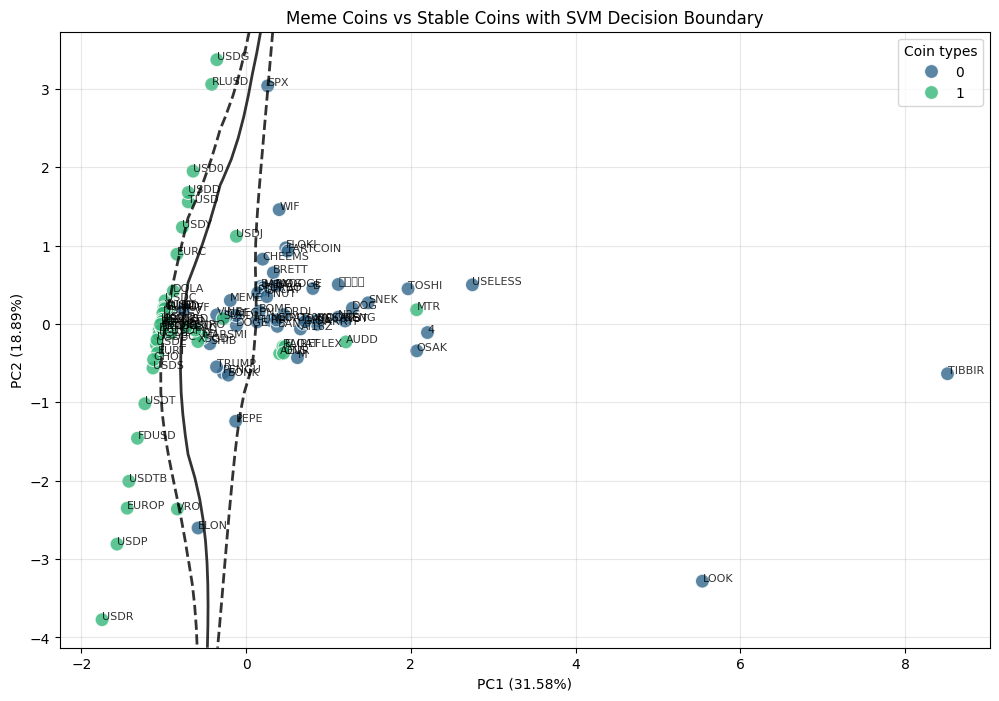

In [226]:
plt.figure(figsize=(12, 8))

plot_df = pca_df[['PC1', 'PC2', 'symbol']].copy()
plot_df['Class'] = df['Class'].values

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Class', 
                palette='viridis', s=100, alpha=0.8)

for i, row in plot_df.iterrows():
    plt.annotate(row['symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

Z = svc_poly.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.8, 
           linestyles=['--', '-', '--'], linewidths=2)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('Meme Coins vs Stable Coins with SVM Decision Boundary')
plt.legend(title='Coin types')
plt.grid(True, alpha=0.3)
plt.show()

In [227]:
svc_rbf = SVC(C=10, kernel='rbf')
svc_rbf.fit(X_train, y_train)

,C,10
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24065 (\N{CJK UNIFIED IDEOGRAPH-5E01}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23433 (\N{CJK UNIFIED IDEOGRAPH-5B89}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-package

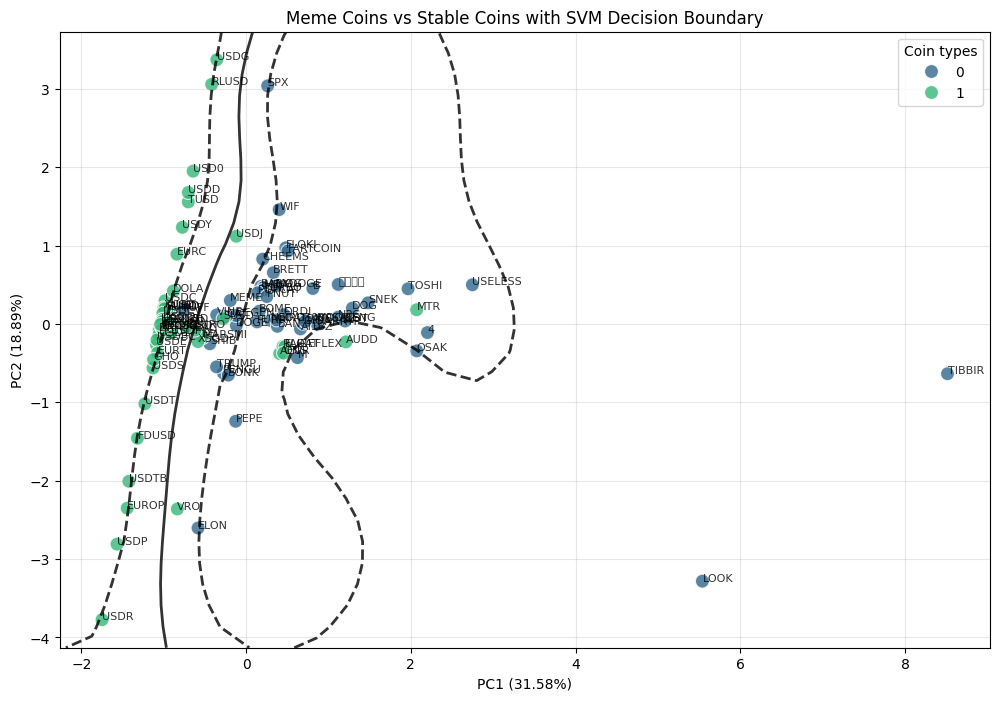

In [228]:
plt.figure(figsize=(12, 8))

plot_df = pca_df[['PC1', 'PC2', 'symbol']].copy()
plot_df['Class'] = df['Class'].values

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Class', 
                palette='viridis', s=100, alpha=0.8)

for i, row in plot_df.iterrows():
    plt.annotate(row['symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

Z = svc_rbf.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.8, 
           linestyles=['--', '-', '--'], linewidths=2)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('Meme Coins vs Stable Coins with SVM Decision Boundary')
plt.legend(title='Coin types')
plt.grid(True, alpha=0.3)
plt.show()

In [229]:
svc_sigmoid = SVC(kernel='sigmoid')
svc_sigmoid.fit(X_train, y_train)

,C,1.0
,kernel,'sigmoid'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24065 (\N{CJK UNIFIED IDEOGRAPH-5E01}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23433 (\N{CJK UNIFIED IDEOGRAPH-5B89}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-package

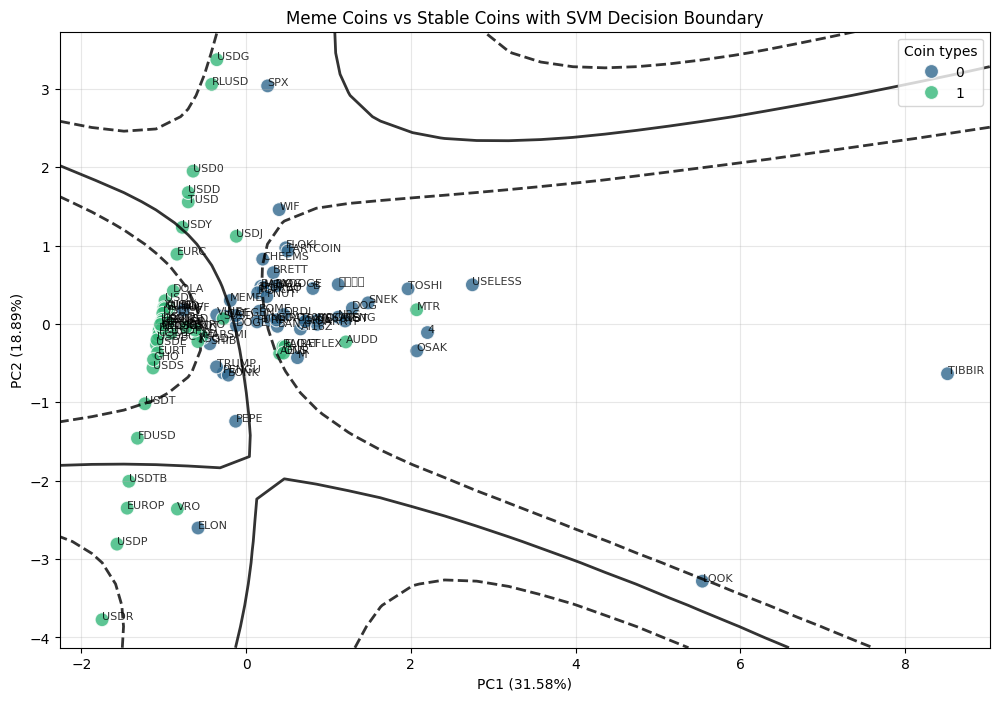

In [230]:
plt.figure(figsize=(12, 8))

plot_df = pca_df[['PC1', 'PC2', 'symbol']].copy()
plot_df['Class'] = df['Class'].values

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Class', 
                palette='viridis', s=100, alpha=0.8)

for i, row in plot_df.iterrows():
    plt.annotate(row['symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

Z = svc_sigmoid.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.8, 
           linestyles=['--', '-', '--'], linewidths=2)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('Meme Coins vs Stable Coins with SVM Decision Boundary')
plt.legend(title='Coin types')
plt.grid(True, alpha=0.3)
plt.show()

In [231]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24065 (\N{CJK UNIFIED IDEOGRAPH-5E01}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23433 (\N{CJK UNIFIED IDEOGRAPH-5B89}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/pyth

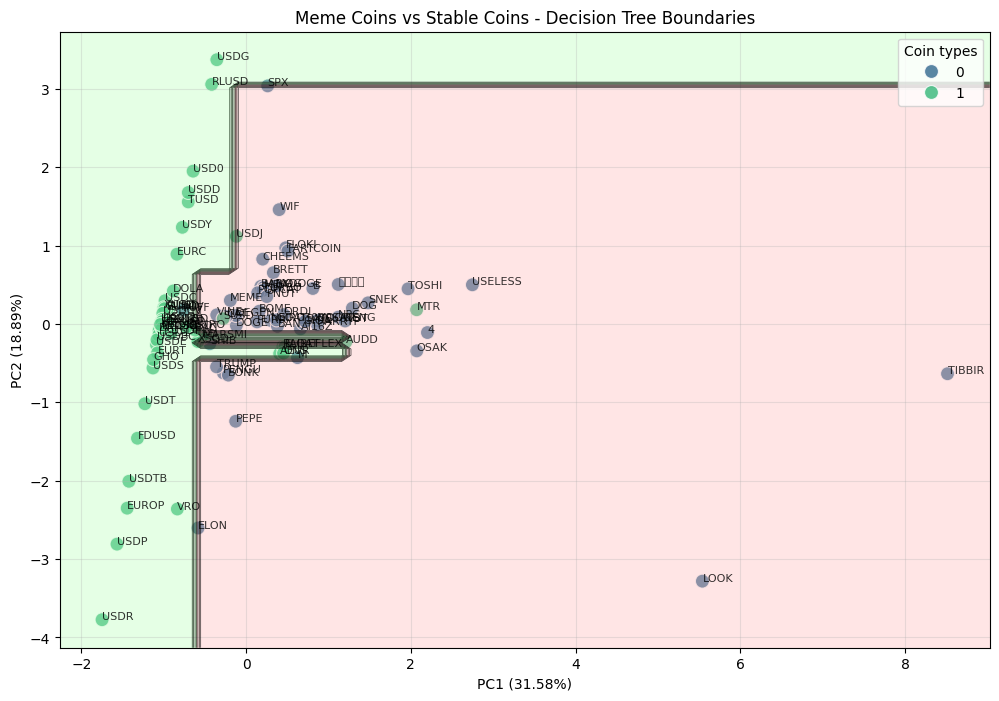

In [232]:
plt.figure(figsize=(12, 8))

plot_df = pca_df[['PC1', 'PC2', 'symbol']].copy()
plot_df['Class'] = df['Class'].values

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Class', 
                palette='viridis', s=100, alpha=0.8)

for i, row in plot_df.iterrows():
    plt.annotate(row['symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 100)
yy = np.linspace(ylim[0], ylim[1], 100)
XX, YY = np.meshgrid(xx, yy)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

Z = tree.predict(xy)
Z = Z.reshape(XX.shape)

from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ['#FF0000', '#00FF00']
plt.contourf(XX, YY, Z, alpha=0.3, cmap=cmap_light)
plt.contour(XX, YY, Z, colors='k', linewidths=0.5, alpha=0.8)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('Meme Coins vs Stable Coins - Decision Tree Boundaries')
plt.legend(title='Coin types')
plt.grid(True, alpha=0.3)
plt.show()

In [233]:
knn_y_pred = knn.predict(X_test)
nearest_centroid_y_pred = nearest_centroid.predict(X_test)
svc_linear_y_pred = svc_linear.predict(X_test)
svc_poly_y_pred = svc_poly.predict(X_test)
svc_rbf_y_pred = svc_rbf.predict(X_test)
svc_sigmoid_y_pred = svc_sigmoid.predict(X_test)
tree_y_pred = tree.predict(X_test)

In [234]:
print(f"Accuracy of KNN: {accuracy_score(y_test, knn_y_pred, normalize=True) * 100}%")
print(f"Accuracy of nearest centroid: {accuracy_score(y_test, nearest_centroid_y_pred, normalize=True) * 100}%")
print(f"Accuracy of linear SVC: {accuracy_score(y_test, svc_linear_y_pred, normalize=True) * 100}%")
print(f"Accuracy of polynomial SVC: {accuracy_score(y_test, svc_poly_y_pred, normalize=True) * 100}%")
print(f"Accuracy of RBF SVC: {accuracy_score(y_test, svc_rbf_y_pred, normalize=True) * 100}%")
print(f"Accuracy of sigmoid SVC: {accuracy_score(y_test, svc_sigmoid_y_pred, normalize=True) * 100}%")
print(f"Accuracy of decision trees: {accuracy_score(y_test, tree_y_pred, normalize=True) * 100}%")

Accuracy of KNN: 80.0%
Accuracy of nearest centroid: 65.0%
Accuracy of linear SVC: 75.0%
Accuracy of polynomial SVC: 80.0%
Accuracy of RBF SVC: 80.0%
Accuracy of sigmoid SVC: 60.0%
Accuracy of decision trees: 80.0%


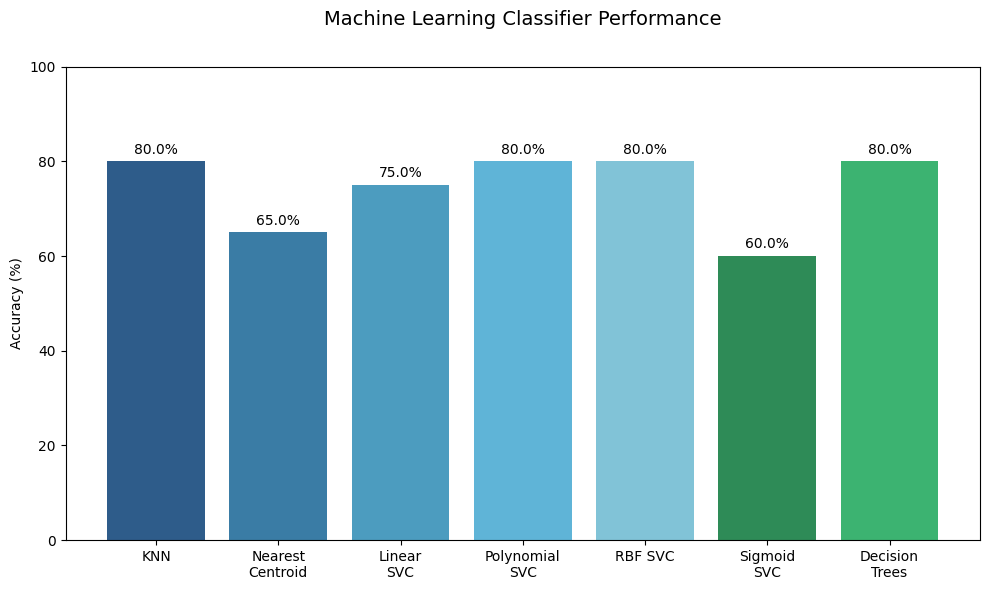

In [235]:
accuracies = [
    accuracy_score(y_test, knn_y_pred, normalize=True) * 100,
    accuracy_score(y_test, nearest_centroid_y_pred, normalize=True) * 100,
    accuracy_score(y_test, svc_linear_y_pred, normalize=True) * 100,
    accuracy_score(y_test, svc_poly_y_pred, normalize=True) * 100,
    accuracy_score(y_test, svc_rbf_y_pred, normalize=True) * 100,
    accuracy_score(y_test, svc_sigmoid_y_pred, normalize=True) * 100,
    accuracy_score(y_test, tree_y_pred, normalize=True) * 100
]

classifiers = ['KNN', 'Nearest\nCentroid', 'Linear\nSVC', 'Polynomial\nSVC', 
               'RBF SVC', 'Sigmoid\nSVC', 'Decision\nTrees']

plt.figure(figsize=(10, 6))
bars = plt.bar(classifiers, accuracies, color = ['#2E5C8A', '#3A7CA5', '#4C9CBF', '#5FB4D7', '#81C3D7', 
                '#2E8B57', '#3CB371'])

plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Machine Learning Classifier Performance', pad=30, fontsize=14)
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{acc:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()